In [1]:
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

In [2]:
!unzip -qq train_task.zip

In [4]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [5]:
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

In [6]:
Y = [1 if x == 'cat' else 0 for x in labels]

1


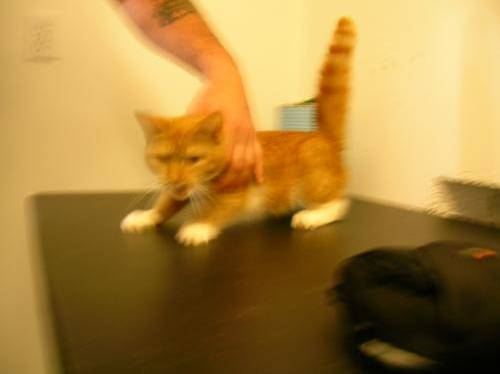

In [7]:
print(Y[0])
Image(filename=imagePaths[0])

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=80)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=13, #количество деревьев
                            random_state=80)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=80),
                  n_estimators=13, random_state=80)

In [10]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = 80, C = 1.25)
svm.fit(trainData, Y)

LinearSVC(C=1.25, random_state=80)

In [11]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=13, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=80)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=13, random_state=80)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=80)

In [13]:
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.25, random_state=80)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=80),
                                                  n_estimators=13,
                                                  random_state=80)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
                                                       n_estimators=13,
                                                       random_state=80))],
                   final_estimator=LogisticRegression(random_state=80))

In [14]:
sclf.score(trainData, Y)

0.843

In [28]:
!unzip -qq test_task.zip

replace test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [39]:
singleImage = cv2.imread('test/dog.1011.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
prediction = sclf.predict(histt2)

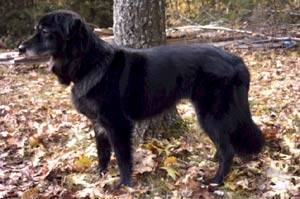

In [42]:
Image(filename='test/dog.1011.jpg')

In [40]:
prediction

array([0])

In [41]:
sclf.predict_proba(histt2)

array([[0.58823011, 0.41176989]])